#ARMA-GARCH Implementation - WTI Crude Oil data

**Notebook Summary**

**Data**: WTI Crude Oil

**Granularity**: monthly data

**Source**: FRED

**Time period**: 1986-01-01 / 2022-01-01

**Models**: ARMA, ARMA-GARCH


# Importing Libraries

In [ ]:
# Importing models
!pip install arch
!pip install pmdarima

# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import scipy as sc
import statsmodels.api as sm
import sklearn
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()

# Load Data

In [41]:
# Daily data
data = pd.read_csv(io.BytesIO(uploaded['MCOILWTICO.csv'])) 

# Exploratory analysis

In [42]:
# Compute the log returns for AAPL stock 
log_returns = np.log(data["MCOILWTICO"]).diff(1) 
data["log_returns"] = log_returns 

# Set the time index
data["DATE"] = pd.to_datetime(data["DATE"]) 
data.set_index("DATE", inplace = True)

In [43]:
data.head()

,MCOILWTICO,log_returns
DATE,,
1986-01-01,22.93,NaN
1986-02-01,15.46,-0.394190
1986-03-01,12.61,-0.203766
1986-04-01,12.84,0.018075
1986-05-01,15.38,0.180503


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1986-01-01 to 2022-01-01
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MCOILWTICO   433 non-null    float64
 1   log_returns  432 non-null    float64
dtypes: float64(2)
memory usage: 10.1 KB


Text(0.5, 1.0, 'QQ Plot WTI Crude Oil returns')

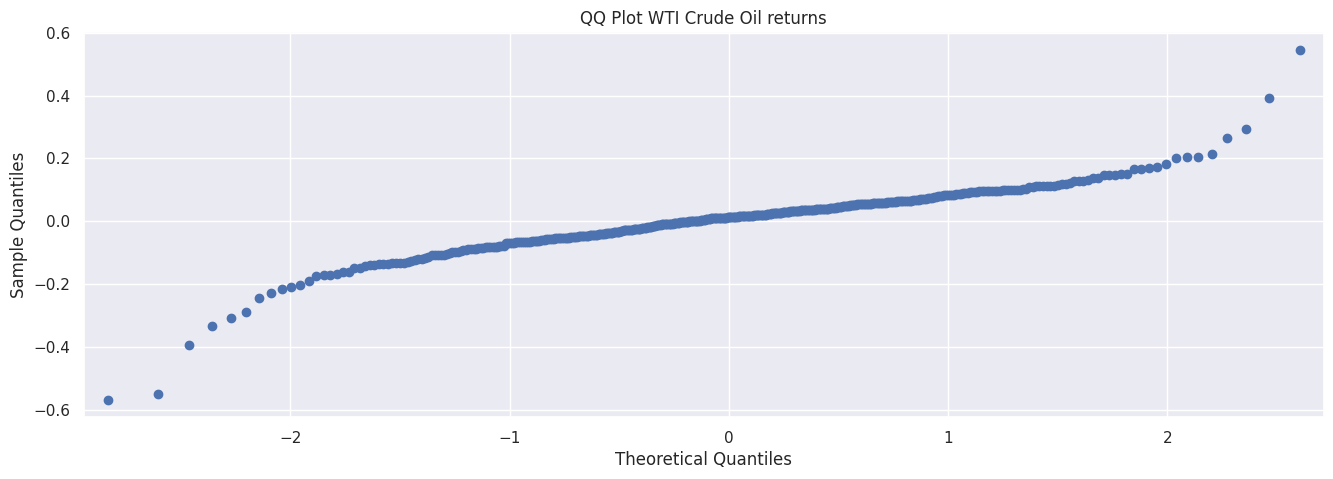

In [45]:
# Plot the Q-Q plot for log returns
from statsmodels.graphics.gofplots import qqplot as qq
qq_plot = qq(data['log_returns'], line='s')
plt.title('QQ Plot WTI Crude Oil returns')

In [46]:
# Get summary statistics of the data
mean = data['log_returns'].mean()
std = data['log_returns'].std()
skew = data['log_returns'].skew()
kurtosis = data['log_returns'].kurtosis()

print("Mean: ", mean,
      "\nStandard Deviation:", std, 
      "\nSkewness:", skew, 
      "\nKurtosis:", kurtosis)

Mean:  0.0029838926080670877 
Standard Deviation: 0.09869116825355363 
Skewness: -0.6928148498384483 
Kurtosis: 7.4687143493576


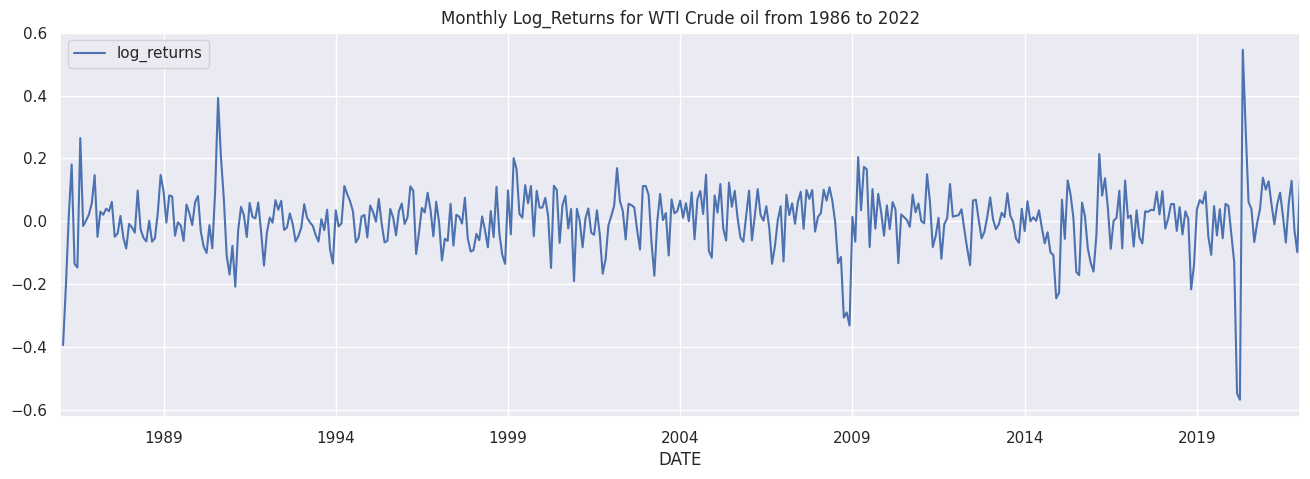

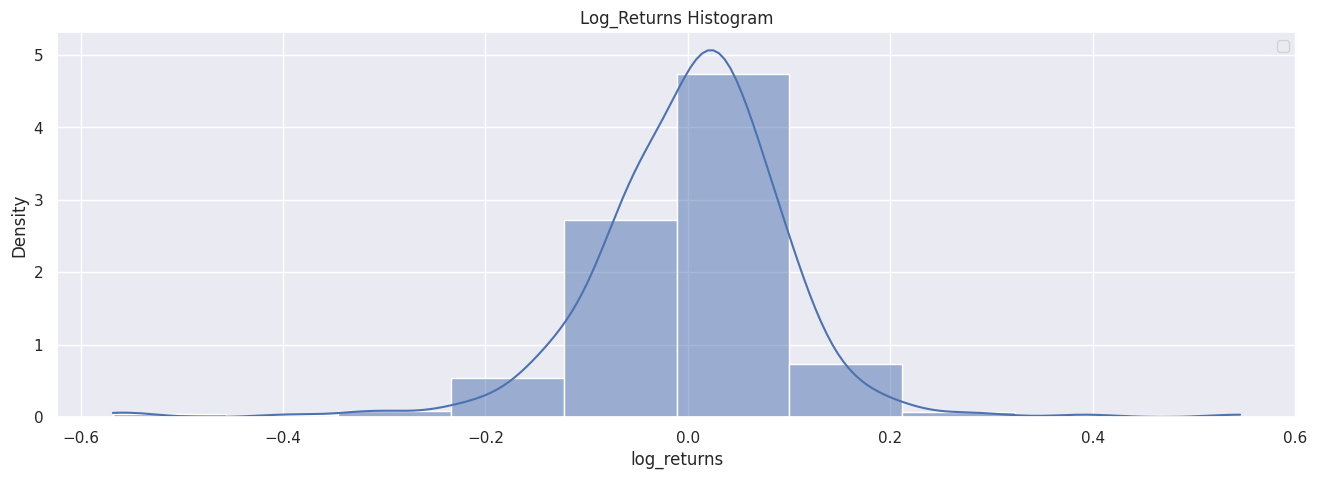

In [47]:
# Plots the log_returns
x = np.linspace(-10,10,1000)
data.plot(y = "log_returns", title = "Monthly Log_Returns for WTI Crude oil from 1986 to 2022", legend = True)
plt.show()

# Plot the histogram and kde
sns_ax = sns.histplot(data = data, x = "log_returns", bins=10, stat="density", kde=True)
sns_ax.set_title("Log_Returns Histogram")
plt.legend()
plt.show()


# Refine Dataset

In [48]:
data = data[['log_returns']]

In [49]:
# Drop the first NaN observation
data = data.dropna()
data

,log_returns
DATE,
1986-02-01,-0.394190
1986-03-01,-0.203766
1986-04-01,0.018075
1986-05-01,0.180503
1986-06-01,-0.135577
...,...
2021-09-01,0.056264
2021-10-01,0.128564
2021-11-01,-0.029013


# Train/Test split

In [50]:
# Split data into train and test set
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
print(train_df.shape)
print(test_df.shape)

(395, 1)
(37, 1)


#Decomposition of Time Series

<Figure size 2000x1800 with 0 Axes>

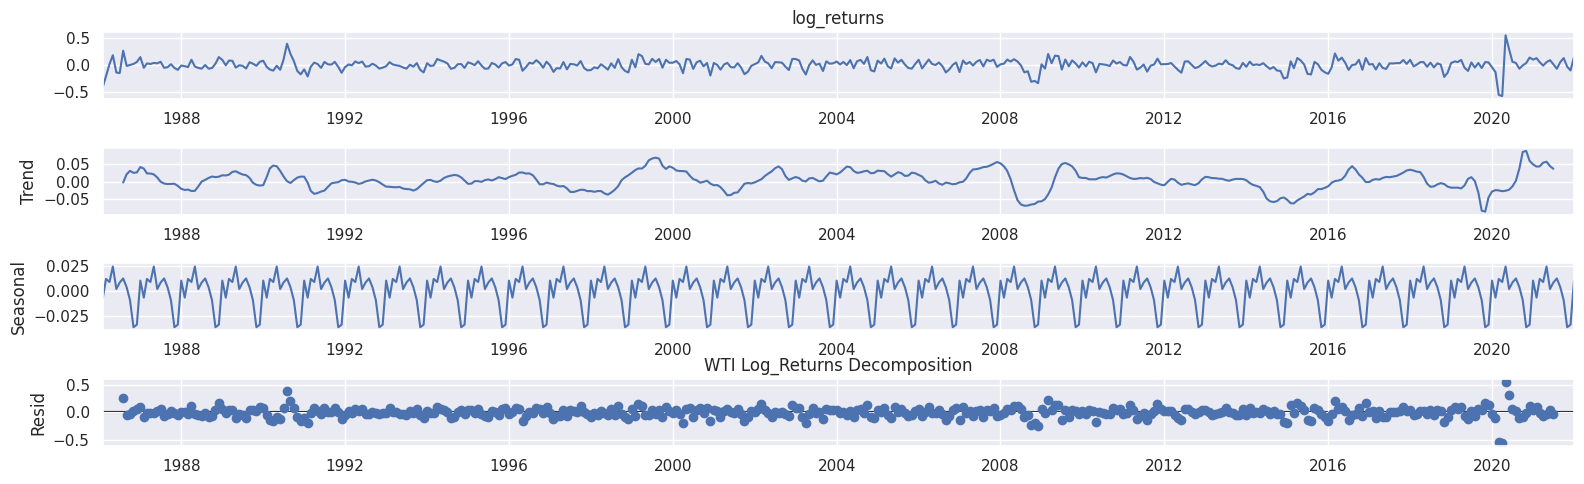

In [51]:
# Plot the decomposition
plt.figure(figsize=(20,18))
decomposed_series = sd(data['log_returns'], model='additive', period = 12)
decomposed_series.plot()
plt.title("WTI Log_Returns Decomposition")
plt.show()

# Stationarity of Time Series
Check that the log_returns are stationary. In the previous example using closing prices, we observe that they are not stationary and a differencing operation is required to fit an ARIMA model.

Augmented Dickey-Fuller(**ADF**) Test

H0)Time series has a unit root - Non-stationary

H1)Time series does not have a unit root - Stationary

**Stationary** if we have constant mean,constant variance and No Trend and Seasonality.

In [52]:
def ad_fuller_function(series):
  results = adfuller(series)
  print('ADF Statistic: %f' % results[0])
  print('p-value: %f' %results[1])
  print('Number of lags %f' %results[2])
  print('Critical Values:')
  
  for k, v in results[4].items():
	  print('\t%s: %.3f' % (k, v))
 
  if results[0] < results[4]['5%']:
    print('Reject H0 - Time Series is Stationary')
  else:
    print('Failed to Reject H0 - Time Series is Non-Stationary')

In [53]:
ad_fuller_function(data)

ADF Statistic: -11.203764
p-value: 0.000000
Number of lags 3.000000
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570
Reject H0 - Time Series is Stationary


The daily returns data is, in fact, stationary, meaning that there is a mean-reversion characteristic. The mean is around zero and the variance is non-constant.

In [54]:
# Check stationarity of data using other statistical tests
y = data['log_returns']
# Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
print("KPSS Test: ",ndiffs(y, test='kpss'))
# Phillips–Perron (PP) test:
print("PP Test: ",ndiffs(y, test='pp'))

KPSS Test:  0
PP Test:  0



*   Augmented Dickey Fuller Test (ADF): is Unit Root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.
*   Kwiatkowski–Phillips–Schmidt–Shin (KPSS): test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root.
* Phillips–Perron Test (PP): is a Unit Root Test, it is a modification of the Dickey Fuller test, and corrects for autocorrelation and heteroscedasticity in the errors.

All these tests suggest than d should be zero, namley no differencing operation is required in this case; analogously one can use stock prices with one differencing to make them stationary.

# ACF-PACF Log Returns

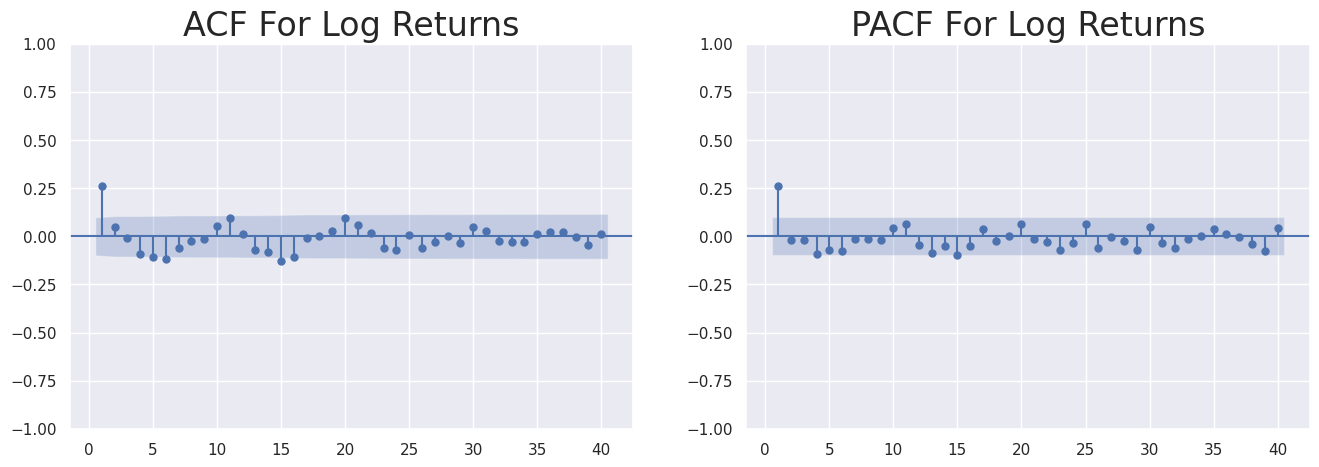

In [55]:
plt.rcParams["figure.figsize"] = 16, 5
fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train_df.log_returns[1:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(train_df.log_returns[1:], zero = False, lags = 40, ax = axes[1])

axes[0].set_title("ACF For Log Returns", size = 24)
axes[1].set_title("PACF For Log Returns", size = 24)

plt.show()

# ARMA

The ARMA(1,1) model is commonly used to fit log returns for stock price prediction due to its ability to capture both the autoregressive (AR) and moving average (MA) components of the time series. Here are some reasons for using an ARMA(1,1) model. (metti riferimenti alla letteratura)

In [56]:
# Instantiate an ARMA(1,1) model and get the results
model = SARIMAX(train_df, order = (1, 0, 1))
model_results = model.fit()
print(model_results.summary())

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                  395
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 419.617
Date:                Sat, 03 Jun 2023   AIC                           -833.234
Time:                        16:49:27   BIC                           -821.298
Sample:                    02-01-1986   HQIC                          -828.505
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2216      0.142      1.563      0.118      -0.056       0.500
ma.L1          0.0734      0.155      0.475      0.635      -0.229       0.376
sigma2         0.0070      0.000     19.143      0.0

In [57]:
# Make forescasts
arma_forecast = model_results.get_forecast(len(test_df.index))
# Create a confidence interval of 90%
arma_predictions_df = arma_forecast.conf_int(alpha = 0.10) 
arma_predictions_df["Predictions"] = model_results.predict(start = len(train_df), end = len(data))


In [58]:
# Display ARMA predictions dataframe
arma_predictions_df

,lower log_returns,upper log_returns,Predictions
2019-01-01,-0.174141,0.100955,-3.659280e-02
2019-02-01,-0.151519,0.135299,-8.109739e-03
2019-03-01,-0.145488,0.141894,-1.797290e-03
2019-04-01,-0.144103,0.143306,-3.983175e-04
2019-05-01,-0.143794,0.143617,-8.827558e-05
2019-06-01,-0.143725,0.143686,-1.956374e-05
2019-07-01,-0.143710,0.143701,-4.335738e-06
2019-08-01,-0.143706,0.143705,-9.608914e-07
2019-09-01,-0.143706,0.143705,-2.129539e-07
2019-10-01,-0.143706,0.143705,-4.719509e-08


In [59]:
arma_predictions_df.index = test_df.index

##Get the MSE and RMSE

In [60]:
arma_mse = mean_squared_error(test_df["log_returns"], arma_predictions_df["Predictions"])
print("ARMA MSE:", arma_mse)
print("ARMA RMSE:", np.sqrt(arma_mse))

ARMA MSE: 0.03256934889840161
ARMA RMSE: 0.18046980051632353


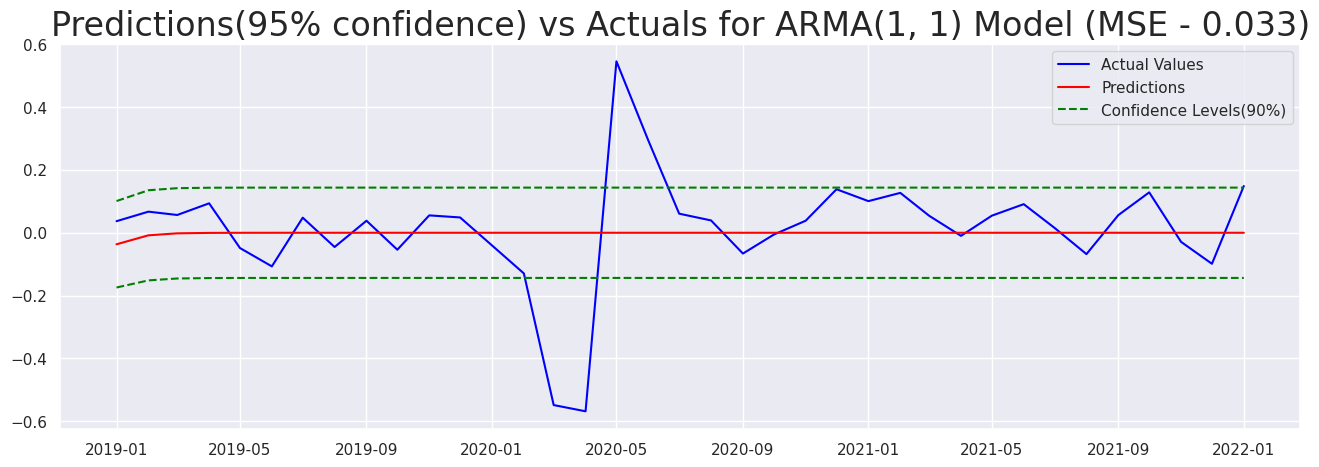

In [61]:
plt.rcParams["figure.figsize"] = 16, 5
plt.plot(test_df["log_returns"], color = "blue", label = "Actual Values")

plt.plot(arma_predictions_df["Predictions"], color = "red", label = "Predictions")
plt.plot(arma_predictions_df["upper log_returns"], color = "green", linestyle = "--", label = "Confidence Levels(90%)")
plt.plot(arma_predictions_df["lower log_returns"], color = "green", linestyle = "--")

plt.title(f"Predictions(95% confidence) vs Actuals for ARMA(1, 1) Model (MSE - {(np.round(arma_mse, 3))})", size = 24)
plt.legend()
plt.show()

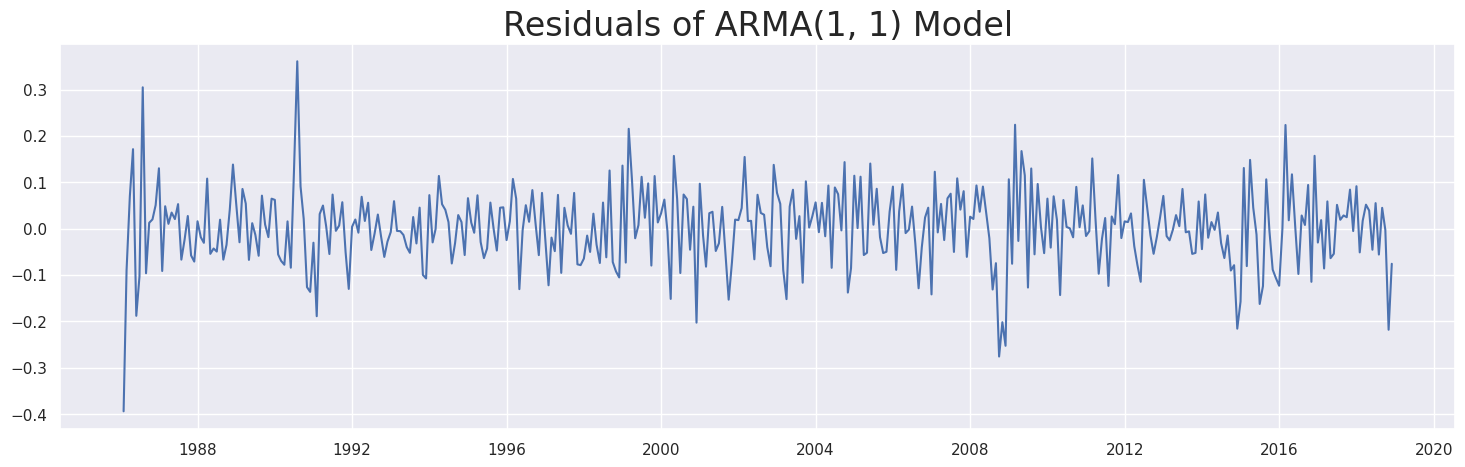

In [62]:
# Plotting Residuals of ARMA(1, 1) Model
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(model_results.resid)
plt.title("Residuals of ARMA(1, 1) Model", size = 24)
plt.show()

Thanks to this plot we can observe that the variance varies with time, thus modeling it with a GARCH model seams a reasonable option.

# ARMA-GARCH

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                  395
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 419.649
Date:                Sat, 03 Jun 2023   AIC                           -831.298
Time:                        16:49:30   BIC                           -815.383
Sample:                    02-01-1986   HQIC                          -824.992
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.006      0.245      0.806      -0.010       0.013
ar.L1          0.2198      0.143      1.536      0.124      -0.061       0.500
ma.L1          0.0749      0.155      0.484      0.6

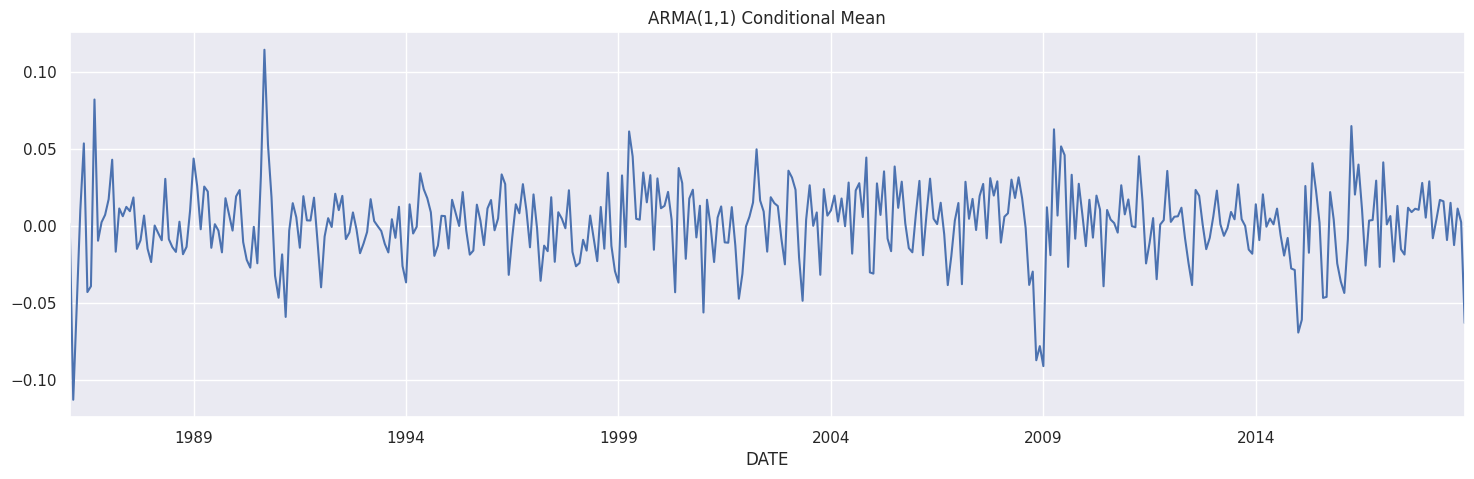

Iteration:      1,   Func. Count:      6,   Neg. LLF: 752202.4759127109
Iteration:      2,   Func. Count:     16,   Neg. LLF: 825.8212593164296
Iteration:      3,   Func. Count:     25,   Neg. LLF: -404.4762866598977
Iteration:      4,   Func. Count:     32,   Neg. LLF: -417.3995939669968
Iteration:      5,   Func. Count:     38,   Neg. LLF: -436.7271515250003
Iteration:      6,   Func. Count:     44,   Neg. LLF: -442.6254073150276
Iteration:      7,   Func. Count:     49,   Neg. LLF: -442.62545333103617
Iteration:      8,   Func. Count:     54,   Neg. LLF: -442.6254581754091
Iteration:      9,   Func. Count:     58,   Neg. LLF: -442.62545817541616
Optimization terminated successfully    (Exit mode 0)
            Current function value: -442.6254581754091
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:      

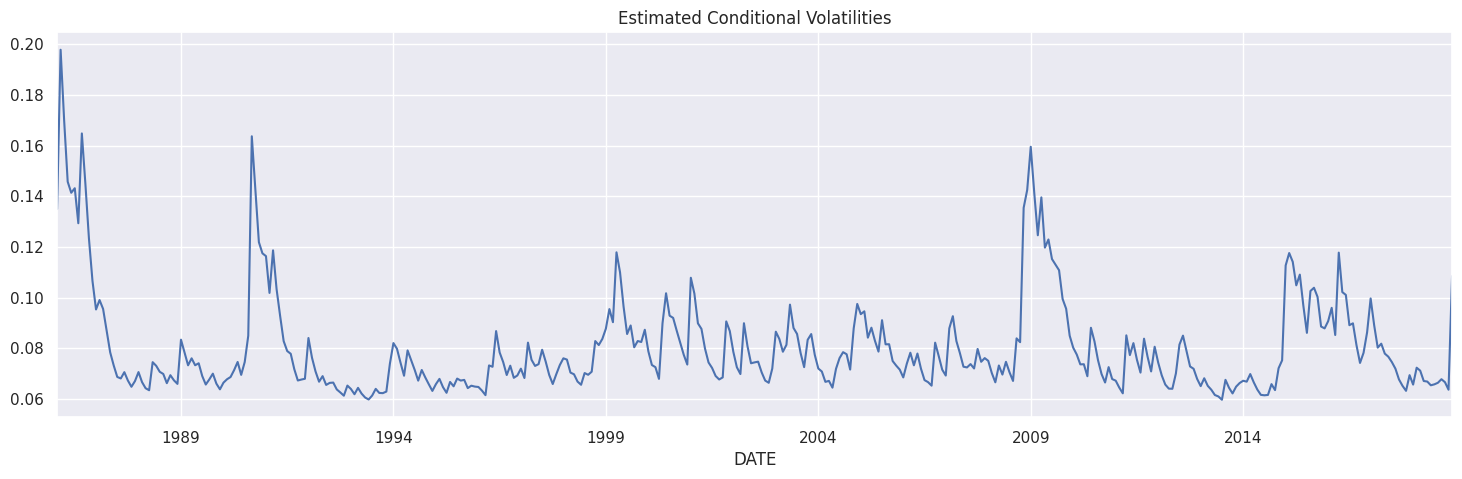

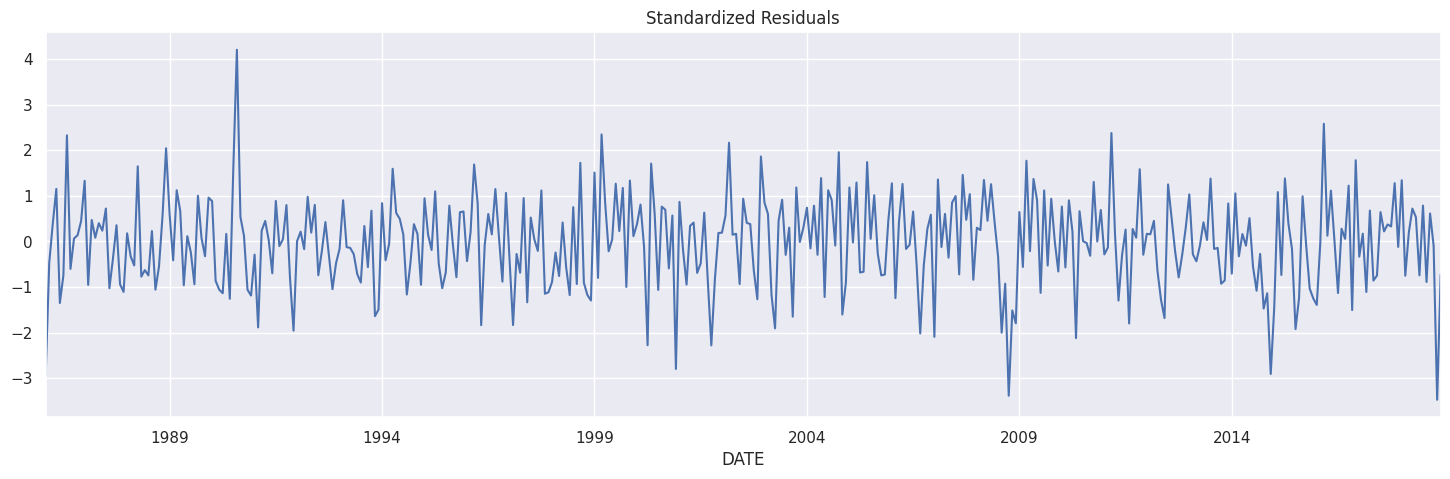

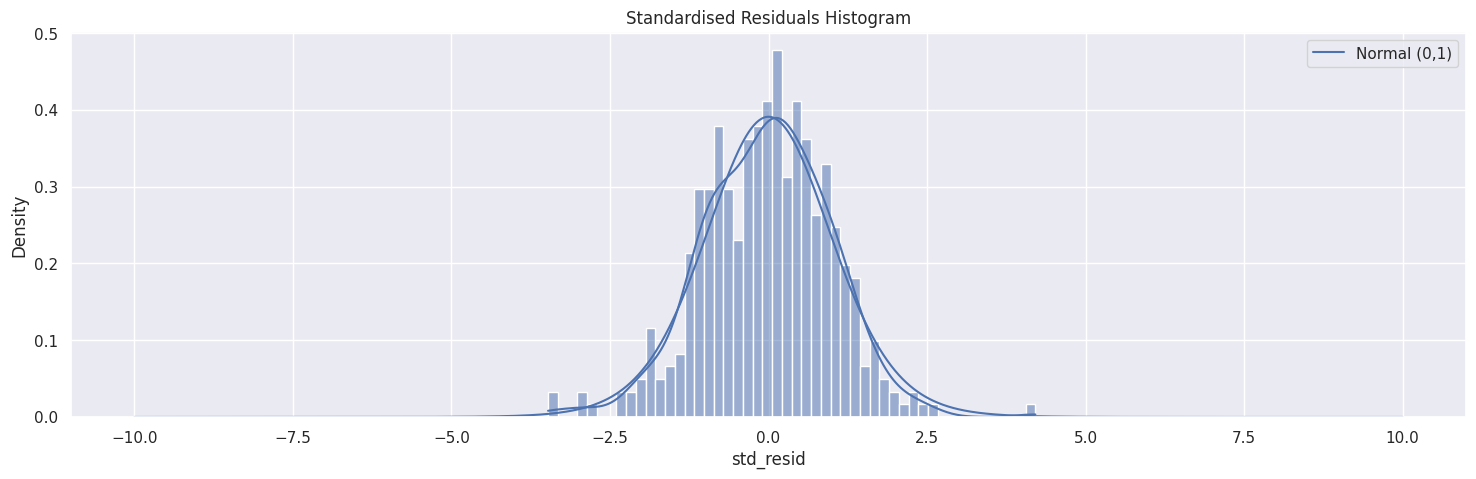

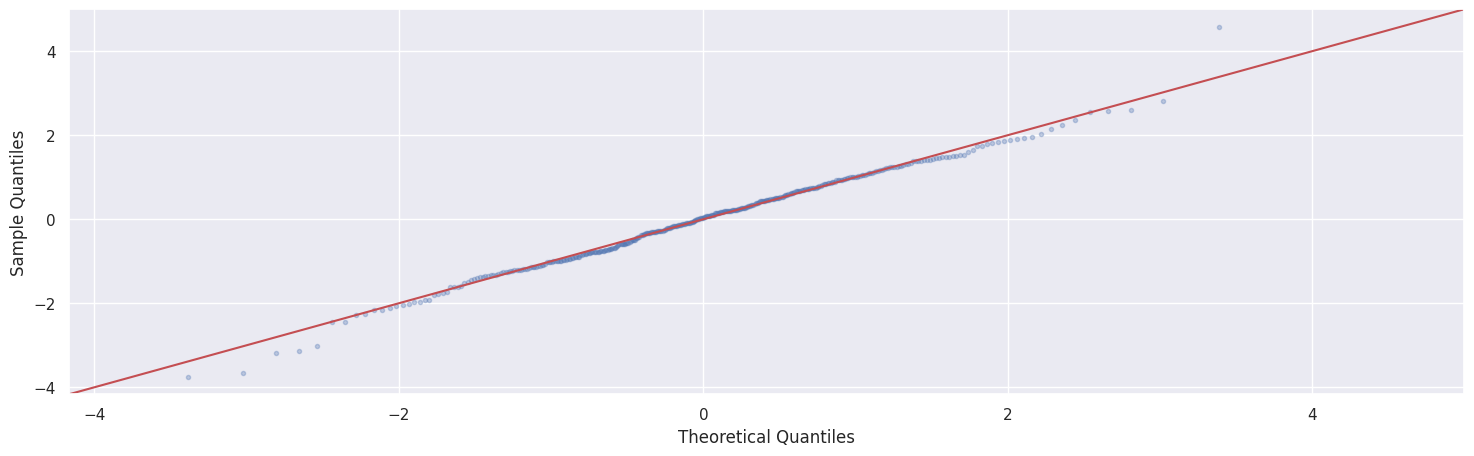

In [63]:
#First approach: fit an ARMA and subsequently a GARCH model on the residuals, with a focus on statistical properties and plot
 
# Fitting an ARMA(1,1) Process to the Log_returns
arma = ARIMA(train_df, order = (1,0,1))
results = arma.fit()
residuals = results.resid
print(results.summary())
fitted_vals = results.fittedvalues

# Plotting the Conditional Mean of the ARMA(1,1) Component
fitted_vals.plot(title = "ARMA(1,1) Conditional Mean")
plt.show()

# Fitting a GARCH(1,1) Process to the residuals
garch = arch_model(residuals, p = 1, q = 1, vol = "GARCH")
result2 = garch.fit()
print(result2.summary())


# Plotting the ARMA(1,1)- GARCH(1,1) Results
# Conditional Volatilities
fig = result2.conditional_volatility.plot(title = "Estimated Conditional Volatilities")
plt.show()

# Std Residuals
fig1 = result2.std_resid.plot(title = "Standardized Residuals") # viz
plt.show()

sns_ax = sns.histplot(result2.std_resid, bins=50, stat="density", kde=True) # histogram with kde and fitted normal
sns_ax.set_title("Standardised Residuals Histogram")
params = sc.stats.t.fit(result2.std_resid)
sns_ax.plot(x,sc.stats.t.pdf(x, params[0]),label=f"Normal (0,1)")
plt.legend()
plt.show()

pp = sm.ProbPlot(result2.std_resid, fit=True, dist = sc.stats.t) # qqplot
qq = pp.qqplot(marker='.', markerfacecolor='b', markeredgecolor='b', alpha=0.3)
sm.qqline(qq.axes[0], line='45', fmt='r')
plt.show()

1. **Standardized residuals plot**, if the model is working correctly, there should be no obvious pattern in the residuals, they should be scattered.
2. **Histogram and Density plot**, it shows the distribution fo the residuals, if the model is good, the orange and green line should be almost the same.
3. **Q-Q plot**, it compares the distributionof the residuals to a normal distribution, if the residuals are normally distributed, all the points should lie across the the red line.
4. **Correlogram plot**, is the ACF plot of the residuals rather than the data, the model is doing well as long as the graph stays within the shaded area.

In [64]:
# Second approach: get residuals and use them to make forecasts
resid_df = data.copy() # make a copy of original data
resid_df["log_returns_resid"] = resid_df["log_returns"].loc[resid_df.index]
resid_df["log_returns_resid"].loc[train_df.index] = model_results.resid

In [65]:
resid_df

,log_returns,log_returns_resid
DATE,,
1986-02-01,-0.394190,-0.394190
1986-03-01,-0.203766,-0.089896
1986-04-01,0.018075,0.069830
1986-05-01,0.180503,0.171371
1986-06-01,-0.135577,-0.188160
...,...,...
2021-09-01,0.056264,0.056264
2021-10-01,0.128564,0.128564
2021-11-01,-0.029013,-0.029013


In [66]:
# Fit the GARCH model
resid_model = arch_model(resid_df["log_returns_resid"], p = 1, q = 1, vol = "GARCH")
resid_model_results = resid_model.fit(last_obs = test_df.index[0])
resid_model_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 748943.1035246529
Iteration:      2,   Func. Count:     16,   Neg. LLF: 825.849381826424
Iteration:      3,   Func. Count:     25,   Neg. LLF: -404.50639137955363
Iteration:      4,   Func. Count:     32,   Neg. LLF: -417.42332180194387
Iteration:      5,   Func. Count:     38,   Neg. LLF: -436.67541179305124
Iteration:      6,   Func. Count:     44,   Neg. LLF: -442.61613668115217
Iteration:      7,   Func. Count:     49,   Neg. LLF: -442.6161826681214
Iteration:      8,   Func. Count:     54,   Neg. LLF: -442.61618753010674
Iteration:      9,   Func. Count:     58,   Neg. LLF: -442.61618753011373
Optimization terminated successfully    (Exit mode 0)
            Current function value: -442.61618753010674
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:      log_returns_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                442.616
Distribution:                  Normal   AIC:                          -877.232
Method:            Maximum Likelihood   BIC:                          -861.317
                                        No. Observations:                  395
Date:                Sat, Jun 03 2023   Df Residuals:                      394
Time:                        16:49:34   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.1714e-03  3.589e-03      0.884      0.377 [-3.864e-03,1.021e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0548e-03  3.578e-04      2.948  3.202e-03 [3.534e-04,1.756e-03]
alpha[1]       0.1631  6.716e-02      2.428  1.517e-02   [3.145e-02,  0.295]
beta[1]        0.6745  8.189e-02      8.237  1.771e-16     [  0.514,  0.835]
============================================================================

Covariance estimator: robust
"""

In [67]:
resid_forecasts = resid_model_results.forecast().residual_variance
resid_forecasts = resid_forecasts.loc[test_df.index].values

In [68]:
resid_forecasts.shape

(37, 1)

In [69]:
# Get the predictions from ARMA-GARCH model
arma_garch_predictions_df = arma_predictions_df.copy().loc[test_df.index]
arma_garch_predictions_df["lower log_returns"] = arma_garch_predictions_df["Predictions"] - np.sqrt(resid_forecasts.reshape(-1,))*1.65
arma_garch_predictions_df["upper log_returns"] = arma_garch_predictions_df["Predictions"] + np.sqrt(resid_forecasts.reshape(-1,))*1.65

In [70]:
arma_garch_predictions_df

,lower log_returns,upper log_returns,Predictions
DATE,,,
2019-01-01,-0.184182,0.110996,-3.659280e-02
2019-02-01,-0.147332,0.131113,-8.109739e-03
2019-03-01,-0.132996,0.129401,-1.797290e-03
2019-04-01,-0.135002,0.134205,-3.983175e-04
2019-05-01,-0.127693,0.127516,-8.827558e-05
2019-06-01,-0.138723,0.138684,-1.956374e-05
2019-07-01,-0.129396,0.129387,-4.335738e-06
2019-08-01,-0.123320,0.123318,-9.608914e-07
2019-09-01,-0.116950,0.116949,-2.129539e-07


[]

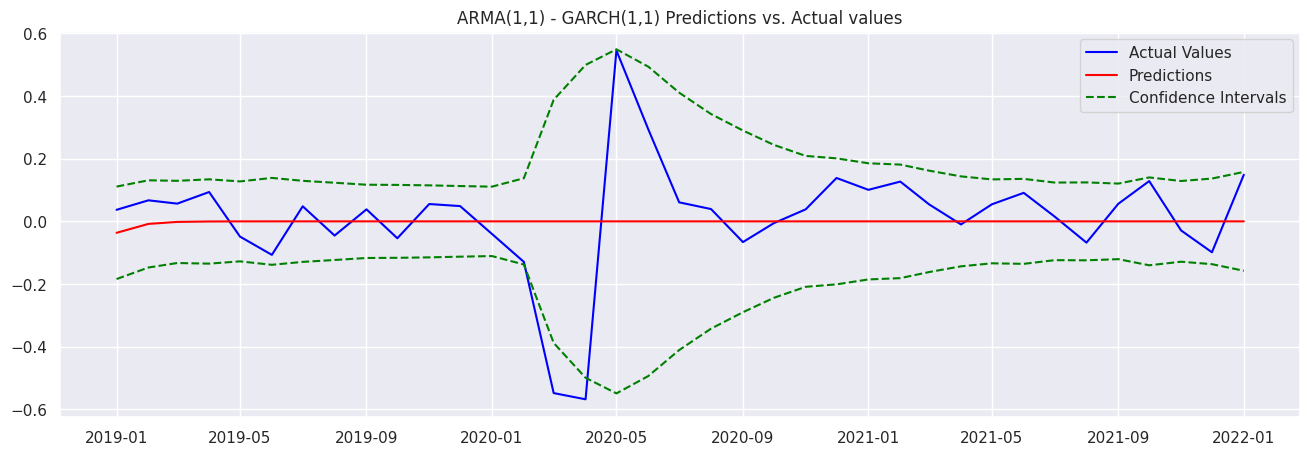

In [71]:
# Plot the results
plt.rcParams["figure.figsize"] = 16, 5

plt.plot(test_df["log_returns"], color = "blue", label = "Actual Values")
plt.plot(arma_garch_predictions_df["Predictions"], color = "red", label = "Predictions")
plt.plot(arma_garch_predictions_df["lower log_returns"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(arma_garch_predictions_df["upper log_returns"], color = "green", linestyle = "--")
plt.title("ARMA(1,1) - GARCH(1,1) Predictions vs. Actual values")
plt.legend()
plt.plot()

# Rolling window Forecast

In [72]:
# Define look_back and look_forward variables
look_back = 48
look_forward = 6

times_exploded = []
forecasts = []
for i in range(len(data)- look_back - look_forward):
  model = SARIMAX(data.iloc[i: i+ look_back], order = (1,0,1))
  results = model.fit()
  hist = results.forecast(steps = look_forward)
  times_exploded.append(data.index[i + look_back : i + look_back + look_forward])
  forecasts.append(hist.values)


#Plot the results

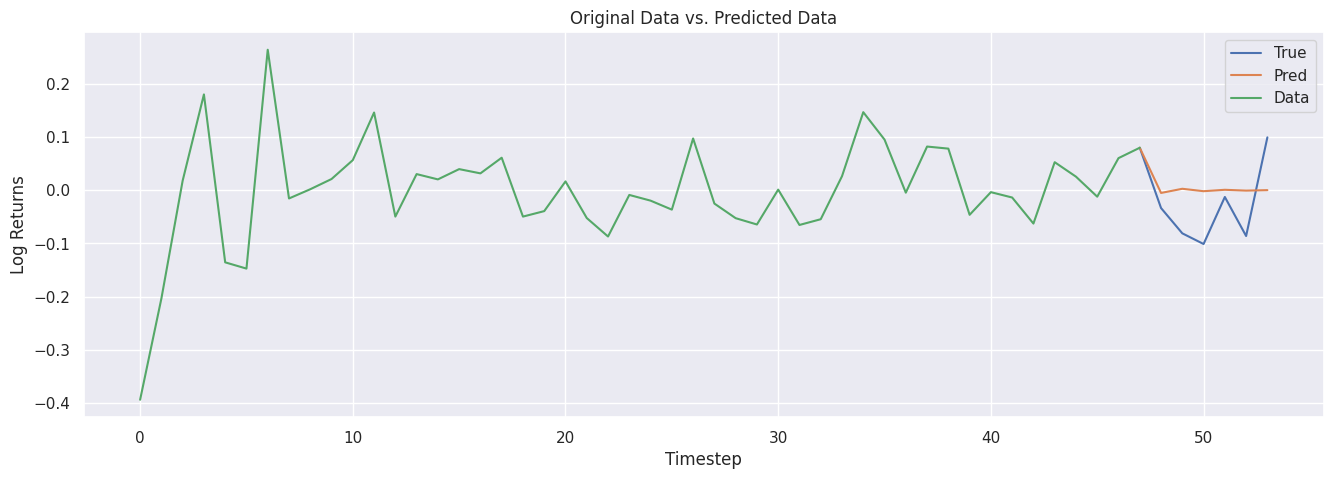

In [73]:
# Plot
plt.plot(list(range(look_back -1,look_back + look_forward)), data.iloc[look_back - 1: look_back + look_forward] , label = 'True')
plt.plot(list(range(look_back -1, look_back + look_forward)), np.insert(forecasts[0], 0, data.iloc[look_back-1]) ,  label='Pred')
plt.plot(list(range(0, look_back)), data.iloc[0: look_back] , label='Data')


# Set plot labels and title
plt.xlabel('Timestep')
plt.ylabel('Log Returns')
plt.title('Original Data vs. Predicted Data')

# Add legend
plt.legend()

# Display the plot
plt.show()